This code was adapted from Chris Holden (ceholden@gmail.com) Chaoter 5 Lesson on Ladncover Classification: https://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html - https://github.com/ceholden



### Imports

In [1]:
# Import Python 3's print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Sklearn Libraries
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, \
            classification_report, recall_score, precision_recall_curve
from sklearn.metrics import accuracy_score
from pprint import pprint


### Preparing The Dataset

In [2]:
# Read in our satellite and label image
satellite_img = gdal.Open('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/classification_training_data/final_filled_l8_training_data.tif', gdal.GA_ReadOnly)
training_img = gdal.Open('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/classification_training_data/third_remerge_landcover_training_data.tif', gdal.GA_ReadOnly)


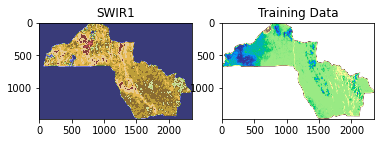

In [3]:

img = np.zeros((satellite_img.RasterYSize, satellite_img.RasterXSize, satellite_img.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(satellite_img.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = satellite_img.GetRasterBand(b + 1).ReadAsArray()
    
lbls = training_img.GetRasterBand(1).ReadAsArray().astype(np.uint8)

# Display them
plt.subplot(121)
plt.imshow(img[:, :, 4], cmap=plt.cm.tab20b)
plt.title('SWIR1')

plt.subplot(122)
plt.imshow(lbls, cmap=plt.cm.terrain)
plt.title('Training Data')

plt.show()

In [4]:
img.shape

(1483, 2353, 7)

In [5]:
lbls.shape

(1483, 2353)

Creating the X feature matrix array and the y labels matrix to be fed into the Random Forest

In [6]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (lbls !=7).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(lbls[lbls !=7])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

#this is a quick numpy trick for flattening
X = img[lbls !=7]  # include 8th band, which is Fmask, for now
y = lbls[lbls !=7]


print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))



We have 3489499 samples
The training data include 6 classes: [1 2 3 4 5 6]
Our X matrix is sized: (3489499, 7)
Our y array is sized: (3489499,)


### Training The Random Forest

In [7]:
#stratified k-cross validation to balance the classes
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)

10

In [8]:
StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [ 248321  248322  248323 ... 3489496 3489497 3489498] TEST: [     0      1      2 ... 770848 770849 770850]
TRAIN: [      0       1       2 ... 3489496 3489497 3489498] TEST: [ 248321  248322  248323 ... 1092967 1092968 1092969]
TRAIN: [      0       1       2 ... 3489496 3489497 3489498] TEST: [ 297221  297283  297285 ... 1733559 1733560 1733561]
TRAIN: [      0       1       2 ... 3489496 3489497 3489498] TEST: [ 311277  311278  311279 ... 1910226 1910230 1910231]
TRAIN: [      0       1       2 ... 3489496 3489497 3489498] TEST: [ 325360  325361  325362 ... 2025564 2025565 2025566]
TRAIN: [      0       1       2 ... 3489496 3489497 3489498] TEST: [ 337126  337127  337128 ... 2220858 2220859 2220860]
TRAIN: [      0       1       2 ... 3489496 3489497 3489498] TEST: [ 346611  346612  348880 ... 2553425 2553426 2553427]
TRAIN: [      0       1       2 ... 3489496 3489497 3489498] TEST: [ 360663  360664  360665 ... 2901754 2901755 2901756]
TRAIN: [      0       1       2 ... 34

In [9]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #stratify=y, random_state=123456

In [10]:
X.max()

4220.8759765625

In [11]:
y.max()

6

In [12]:
X_train.shape

(3140550, 7)

In [13]:
X_test.shape

(348949, 7)

In [14]:
y_train.shape

(3140550,)

In [15]:
y_test.shape

(348949,)

In [16]:
# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)


In [17]:

# Fit our model to training data
train = rf.fit(X_train, y_train)

### Training Performance

In [18]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))


Our OOB prediction of accuracy is: 92.96037318304118%


In [19]:
import pandas as pd

# Setup a dataframe -- just like R
df = pd.DataFrame()
df['truth'] = y_train
df['predict'] = rf.predict(X_train)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict      1       2       3     4      5        6      All
truth                                                        
1        96843       0       0     0      0    11315   108158
2            0  145568       0     0      0    16262   161830
3            0       0  873338     0      0    13048   886386
4            0       0       0  3573      0       60     3633
5            0       0       0     0  28144     2187    30331
6            0       0       0     0      0  1950212  1950212
All      96843  145568  873338  3573  28144  1993084  3140550


### Validation Performance

In [20]:
val = rf.predict(X_test)

In [25]:
target_names = ['Cropland', 'Shrubland', 'Forest', 'Grassland', 'Urban', 'Water']

In [26]:
print(classification_report(y_test, val, target_names=target_names))

              precision    recall  f1-score   support

    Cropland       0.37      0.10      0.16     12018
   Shrubland       0.22      0.06      0.09     17981
      Forest       0.77      0.95      0.85     98487
   Grassland       0.00      0.01      0.01       403
       Urban       0.85      0.06      0.12      3370
       Water       0.99      1.00      1.00    216690

    accuracy                           0.90    348949
   macro avg       0.53      0.36      0.37    348949
weighted avg       0.87      0.90      0.87    348949



Confusion matrix:
[[  1188   1045   9434    272      9     70]
 [   807   1067  15628    332     12    135]
 [   999   2614  93624     89      9   1152]
 [   230     23     85      3      8     54]
 [    10    140   2822      0    213    185]
 [     0      0      0      0      0 216690]]


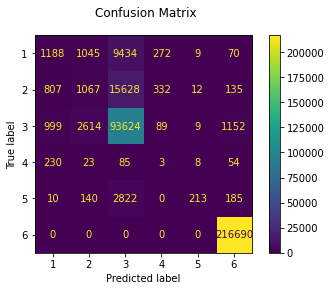

In [23]:
disp = metrics.plot_confusion_matrix(rf, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

### Band Importance

In [24]:
bands = [1, 2, 3, 4, 5, 6,7,8,9,10]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.03510919777346954
Band 2 importance: 0.16173536365040767
Band 3 importance: 0.15845396238661907
Band 4 importance: 0.13622324295346275
Band 5 importance: 0.16024654790606402
Band 6 importance: 0.1754169397705177
Band 7 importance: 0.17281474555945936


#### Scientific comment on band importance
The SWIR bands s

In [26]:
#current parameters in use

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())


Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


### Hyperparameter Testing with Grid Search

Methood 1: Code adapted from "Dealing with multiclass data" - https://towardsdatascience.com/dealing-with-multiclass-data-78a1a27c5dcc

In [ ]:
def hyper_param_rf_predict(X_train, y_train, X_test, y_test):
    #rfc = RandomForestClassifier()
    #rfc.fit(X_train, y_train)
    n_optimal_param_grid = {
    'bootstrap': [True],
    'max_depth': [20], #setting this so as not to create a tree that's too big
    #'max_features': [2, 3, 4, 10],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'n_estimators': [500]
    }
    grid_search_optimal = GridSearchCV(estimator = rf, param_grid = n_optimal_param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)
    grid_search_optimal.fit(X_train, y_train)
    rf_pred_gs = grid_search_optimal.predict(X_test)
    print ("Random Forest Train Accuracy Baseline After Grid Search:", metrics.accuracy_score(y_train, grid_search_optimal.predict(X_train)))
    print ("Random Forest Test Accuracy Baseline After Grid Search:", metrics.accuracy_score(y_test, grid_search_optimal.predict(X_test)))
    print(confusion_matrix(y_test,rf_pred_gs))
    print(classification_report(y_test,rf_pred_gs))
    rf_train_acc = metrics.accuracy_score(y_train, rf.predict(X_train))
    rf_test_acc = metrics.accuracy_score(y_test, rf.predict(X_test))


   
    return(rfc_train_acc, rfc_test_accs)


In [ ]:
hyper_param_rf_predict(X_train, y_train, X_test, y_test)

### Hyperparameter Testing with Random Search

Method 2: Code adapted from Hyperparameter Tuning the Random Forest in Python - https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
### cCreate the parameter grid
# Number of trees in random forest
n_estimators = [500]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [20]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

In [ ]:
### Instantiate the random search and fit
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)


Note: The most important arguments in RandomizedSearchCV are n_iter, which controls the number of different combinations to try, and cv which is the number of folds to use for cross validation. More iterations will cover a wider search space and more cv folds reduces the chances of overfitting.

In [ ]:
### Identify the best parameters
rf_random.best_params_

In [ ]:
### Evaluate the performance of the grid search model to the baseline model
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

#baseline
base_model = rf
train = base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

#random grid search
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)


print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))
